In [6]:
## NOTE: mixed models are hard because some have no known inclinations. Have to sample from those...

import numpy as np

import test_eod.generate as generate
import test_eod.getData as getData
from scipy.stats import truncnorm
from math import erf

from collections import OrderedDict

class FML:
    samples = None
    obs = None
    nImportSamp = 0
    scale = 0.

    logAvg = 0.
    f_MCMC = 0.
    logFML = 0.


def lnlike_1comp(theta, obs):
    gamma, xl, xu = theta
    n = len(obs)
    norm = n * np.log((gamma-1.) / (xu**(gamma-1.) - xl**(gamma-1.)) )
    prod = (gamma-2.) * sum([np.log(x) if xl<x<xu else np.inf for x in obs])
    if prod == np.inf:
        prod = -np.inf
    return norm + prod
    
def lnprior_1comp(theta):
    gamma, xl, xu = theta

    lnp = 0.

    if -10. < gamma < 10. and 0. < xl < 30. and xl < xu < 30.:
        lnp += -np.log(20.) - np.log(xu) - np.log(30. - xl)
    else:
        return -np.inf

    return lnp

def lnpost_1comp(theta, obs):
    lp = lnprior_1comp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_1comp(theta, obs)

#######

def lnlike_1comp_mixed(theta, obs):
    x_info, ind = list(obs['x']), list(obs['ind'])
    
    gamma, xl, xu = theta
    n = len(x_info)
    
    prod = sum([ np.log((gamma-ind[i]) / (xu**(gamma-ind[i]) - xl**(gamma-ind[i]))) \
                      + (gamma-1.-ind[i]) * np.log(x) if xl<x<xu else -np.inf for i,x in enumerate(x_info) ])
        
    return prod

def lnprior_1comp_mixed(theta):
    gamma, xl, xu = theta

    lnp = 0.

    if -10. < gamma < 10. and 0. < xl < 30. and xl < xu < 30.:
        lnp += -np.log(20.) - np.log(xu) - np.log(30. - xl)
    else:
        return -np.inf

    return lnp

def lnpost_1comp_mixed(theta, obs):
    lp = lnprior_1comp_mixed(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_1comp_mixed(theta, obs)

#######


def lnlike_2comp(theta, obs):
    f, gamma1, gamma2, xl1, xl2, xu = theta
    prod = 0.
    
    for i,x in enumerate(obs):
        k1 = f      * (gamma1-1.) / (xu**(gamma1-1.) - xl1**(gamma1-1.)) * x**(gamma1-2.)\
            if xl1<x<xu else 0.
        k2 = (1.-f) * (gamma2-1.) / (xu**(gamma2-1.) - xl2**(gamma2-1.)) * x**(gamma2-2.)\
            if xl2<x<xu else 0.
        prod += np.log(k1 + k2)
        
    return prod

def lnprior_2comp(theta):
    f, gamma1, gamma2, xl1, xl2, xu = theta

    lnp = 0.

    if 0. < f < 1. and -10. < gamma1 < 10. and -10. < gamma2 < 10. \
    and 0. < xl1 < xu and 0. < xl2 < xu and xl2 < xu < 30.:
        lnp += -2.*np.log(20.) - 2.*np.log(xu) - np.log(30. - xl2)
    else:
        return -np.inf

    return lnp

def lnpost_2comp(theta, obs):
    lp = lnprior_2comp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_2comp(theta, obs)


######

def lnlike_2comp_mixed(theta, obs):
    x_info, ind = list(obs['x']), list(obs['ind'])
    
    f, gamma1, gamma2, xl1, xl2, xu = theta
      
    prod = 0.
    
    for i,x in enumerate(x_info):
        k1 = f      * (gamma1-ind[i]) / (xu**(gamma1-ind[i]) - xl1**(gamma1-ind[i])) * x**(gamma1-1.-ind[i])\
            if xl1<x<xu else 0.
        k2 = (1.-f) * (gamma2-ind[i]) / (xu**(gamma2-ind[i]) - xl2**(gamma2-ind[i])) * x**(gamma2-1.-ind[i])\
            if xl2<x<xu else 0.
        prod += np.log(k1 + k2)
    
    return prod

def lnprior_2comp_mixed(theta):
    f, gamma1, gamma2, xl1, xl2, xu = theta

    lnp = 0.

    if 0. < f < 1. and -10. < gamma1 < 10. and -10. < gamma2 < 10. \
    and 0. < xl1 < xu and 0. < xl2 < xu and xl2 < xu < 30.:
        lnp += -2.*np.log(20.) - 2.*np.log(xu) - np.log(30. - xl2)
    else:
        return -np.inf

    return lnp

def lnpost_2comp_mixed(theta, obs):
    lp = lnprior_2comp_mixed(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike_2comp_mixed(theta, obs)


######

def matrix_info(dic):
    vals = []
    
    for x in dic:
        vals.append(dic[x])

    covMatrixG = np.cov(vals)
    
    s,logDetSigmaG = np.linalg.slogdet(covMatrixG)
    
    matrixA = np.linalg.cholesky(covMatrixG)

    mediansG = []
    for a in dic:
        mediansG.append(np.median(dic[a]))
        
    return np.array(mediansG), covMatrixG, matrixA, logDetSigmaG

class computeFML(FML):
    def __init__(self, samples, obs, nImportSamps=100000, scale=10.0, model="1comp"):
        self.samples = samples
        self.obs = obs
        self.nImportSamps = nImportSamps
        self.scale = scale
        self.model = model
        self.importSamp = []
        
        if "1comp" in self.model:
            param_keys = ["gamma", "xl", "xu"]
        if "2comp" in self.model:
            param_keys = ["f", "gamma1", "gamma2", "xl1", "xl2", "xu"]
        postSamp = OrderedDict(zip(param_keys, self.samples))
        nPostSamples = len(self.samples[0])
        
        self.mediansG, self.covMatrixG, self.choleskyDecomp, self.logDetSigmaG = matrix_info(postSamp)
                
        nParams = len(param_keys)

        random_values = [ truncnorm.rvs(-self.scale, self.scale, size=nParams) for i in range(self.nImportSamps) ]

        samples = [ [] for i in range(self.nImportSamps) ]
        g_samples = [ [] for i in range(self.nImportSamps) ]
        loggs = [ 0. for i in range(self.nImportSamps) ]

        print("## Drawing importance samples...")

        for x in range(self.nImportSamps):
            dispersion = np.dot( self.choleskyDecomp, np.transpose(random_values[x]) )
            samples[x] = self.mediansG + dispersion
            g_samples[x] = list(samples[x])

            diff = np.subtract(samples[x],self.mediansG)

            logg = -0.5 * (nParams*np.log(2.*np.pi) + self.logDetSigmaG + \
                    np.dot( np.transpose(diff), \
                    np.linalg.solve(self.covMatrixG, np.subtract(samples[x],self.mediansG) ) ) ) - \
                    nParams*np.log(erf(self.scale/np.sqrt(2.)))
            loggs[x] = logg
        
        print("## Done drawing importance samples!")
        print("")

        g_samples_T = np.transpose(g_samples)
        importSamp_dict = OrderedDict()

        for i, item in enumerate(g_samples_T):
            importSamp_dict[param_keys[i]] = item

        self.importSamp = np.transpose([ vals for key, vals in importSamp_dict.items() ])
        print("## Evaluating lnpost at importance samples...")

        logPosteriors = np.array([ np.nan for i in range(self.nImportSamps) ])
        
        if model == "1comp":
            for i in range(nImportSamps):
                logPosteriors[i] = lnpost_1comp(self.importSamp[i], obs)
        
        if model == "1comp_mixed":
            for i in range(nImportSamps):
                logPosteriors[i] = lnpost_1comp_mixed(self.importSamp[i], obs)

        if model == "2comp":
            for i in range(nImportSamps):
                logPosteriors[i] = lnpost_2comp(self.importSamp[i], obs)

        if model == "2comp_mixed":
            for i in range(nImportSamps):
                logPosteriors[i] = lnpost_2comp_mixed(self.importSamp[i], obs)

                
        print("## Done evaluating lnpost!")
        print("")


        logSum = -(9.**99.)

        for i in range(self.nImportSamps):
            diff = logPosteriors[i] - loggs[i]

            logSum = np.logaddexp(logSum, diff)
            if i%1000==0:
                print(str(i+1), str(logSum - np.log(i+1)))

        self.logAvg = logSum - np.log(self.nImportSamps)
        self.f_MCMC = 0.

        print("")
        print("## logAvg: " + str(self.logAvg))

        postSamp_wo_keys = []
        for key in postSamp:
            postSamp_wo_keys.append(postSamp[key])

        postSamp_wo_keys = np.transpose(np.array(postSamp_wo_keys))
        diff = postSamp_wo_keys-self.mediansG

        for j in range(nPostSamples):

            z = np.linalg.solve(self.choleskyDecomp, diff[j])

            if all([abs(k)<=scale for k in z]):
                self.f_MCMC += 1.
            else:
                self.f_MCMC += 0.

        self.f_MCMC = self.f_MCMC/nPostSamples
        self.logFML = self.logAvg - np.log(self.f_MCMC)

        print("## f_MCMC: " + str(self.f_MCMC))
        print("## logFML: " + str(self.logFML))

        print("## FML computed!")
        print("## Done!")

In [8]:
def combine_two_dicts(x, y):
    z = {}
    for k in set(x).intersection(y):
            z[k] = np.array(list(x[k]) + list(y[k]))
    return z

filename_HAT = "./test_eod/sample_HAT+WASP/planets_HAT.in"
filename_WASP = "./test_eod/sample_HAT+WASP/planets_WASP.in"

data_HAT = getData.exoplanetsORG_to_dict(filename_HAT)
data_WASP = getData.exoplanetsORG_to_dict(filename_WASP)
data_all = combine_two_dicts(data_HAT,data_WASP)

Stan_data = getData.create_Stan_input_alltransit(data_all)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
with open("./test_eod/sample_HAT+WASP/postSamp_HAT+WASP_1comp.txt") as f:
    lines = f.readlines()

postSamp_1comp = np.transpose([ list(map(float,l.split())) for l in lines ])
print(postSamp_1comp[0])

[ 0.78733788  0.83934628  0.76408212 ...,  0.65734866  0.77850562
  0.72322524]


In [11]:
obs = getData
IS_1comp = computeFML(postSamp_1comp, obs=Stan_data['xi'], nImportSamps=100000, model="1comp").importSamp
IS_1comp = np.transpose(IS_1comp)

## Drawing importance samples...
## Done drawing importance samples!

## Evaluating lnpost at importance samples...
## Done evaluating lnpost!

1 -2.95126654307e+94
1001 -288.626319326
2001 -288.665004973
3001 -288.690769932
4001 -288.699220475
5001 -288.720575193
6001 -288.737913352
7001 -288.745622829
8001 -288.748976334
9001 -288.69426473
10001 -288.702190253
11001 -288.702466581
12001 -288.703901913
13001 -288.708805517
14001 -288.639425094
15001 -288.645694372
16001 -288.651408962
17001 -288.649922295
18001 -288.653197404
19001 -288.653490699
20001 -288.65861907
21001 -288.665832114
22001 -288.668441694
23001 -288.673865589
24001 -288.675439753
25001 -288.677601788
26001 -288.677990513
27001 -288.683938099
28001 -288.688029506
29001 -288.689152581
30001 -288.682432979
31001 -288.683387543
32001 -288.680153692
33001 -288.682294837
34001 -288.685279831
35001 -288.687916618
36001 -288.689748984
37001 -288.689815738
38001 -288.691547988
39001 -288.693153601
40001 -288.693419846
41001 

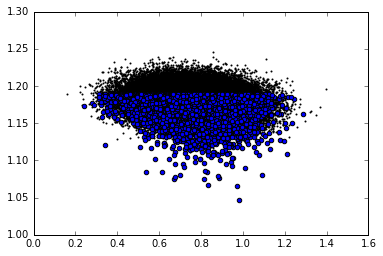

In [12]:
a,b=0,1

plt.scatter(IS_1comp[a], IS_1comp[b], s=1)
plt.scatter(postSamp_1comp[a],postSamp_1comp[b])
plt.show()

In [13]:
with open("./test_eod/sample_HAT+WASP/postSamp_HAT+WASP_2comp_2xl_overlap.txt") as f:
    lines = f.readlines()

tmp = np.transpose([ list(map(float,l.split())) for l in lines ])
postSamp_2comp = np.delete(tmp, 1, 0)

In [14]:
IS_2comp = computeFML(postSamp_2comp, obs=Stan_data['xi'], nImportSamps=500000, model="2comp").importSamp
IS_2comp = np.transpose(IS_2comp)

## Drawing importance samples...
## Done drawing importance samples!

## Evaluating lnpost at importance samples...


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: divide by zero encountered in log


## Done evaluating lnpost!

1 -2.95126654307e+94
1001 -256.081753119
2001 -255.802403249
3001 -255.774543398
4001 -255.612035091
5001 -255.568059704
6001 -255.551927001
7001 -255.547620834
8001 -255.533280743
9001 -255.524471492
10001 -255.490646734
11001 -255.46228024
12001 -255.480333502
13001 -255.445716079
14001 -255.465324088
15001 -255.473059032
16001 -255.478701108
17001 -255.465651468
18001 -255.477985029
19001 -255.475752355
20001 -255.474259757
21001 -255.48518728
22001 -255.464912072
23001 -255.453210588
24001 -255.442866157
25001 -255.424818565
26001 -255.422864763
27001 -255.408084676
28001 -255.410520844
29001 -255.416771735
30001 -255.36983838
31001 -255.354782869
32001 -255.333959019
33001 -255.323696113
34001 -255.321354905
35001 -255.32850513
36001 -255.325755697
37001 -255.317793857
38001 -255.318740945
39001 -255.320597851
40001 -255.321919278
41001 -255.324769415
42001 -255.327414547
43001 -255.327717561
44001 -255.333947137
45001 -255.319910938
46001 -255.32572226

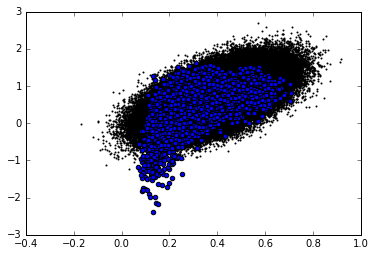

In [16]:
a,b=0,1

plt.scatter(IS_2comp[a], IS_2comp[b], s=1)
plt.scatter(postSamp_2comp[a],postSamp_2comp[b])
plt.show()

In [17]:
def combine_two_dicts(x, y):
    z = {}
    for k in set(x).intersection(y):
        if isinstance(x[k], int):
            z[k] = x[k] + y[k]
        else:
            z[k] = np.array(list(x[k]) + list(y[k]))
    return z


In [18]:
filename_rv = "./test_eod/sample_rv+Kepler/planets_rvall.in"
filename_Kepler = "./test_eod/sample_rv+Kepler/TableKeplerGiants.tex"

data_Kepler = getData.Santerne_to_dict(filename_Kepler)
data_rv = getData.exoplanetsORG_to_dict(filename_rv)

Stan_data_Kepler = getData.create_Stan_input(data_Kepler, transit=1)
Stan_data_rv = getData.create_Stan_input(data_rv, transit=0)
Stan_data = combine_two_dicts(Stan_data_Kepler, Stan_data_rv)

In [19]:
with open("./test_eod/sample_rv+Kepler/postSamp_rv+Kepler_1comp.txt") as f:
    lines = f.readlines()

postSamp_1comp = np.transpose([ list(map(float,l.split())) for l in lines ])
print(postSamp_1comp[0])

[-0.37376013 -0.19862669 -0.11731742 ..., -0.62665085 -0.52486338
 -0.27177117]


In [20]:
obs = getData
IS_1comp = computeFML(postSamp_1comp, obs=Stan_data, nImportSamps=100000, model="1comp_mixed").importSamp
IS_1comp = np.transpose(IS_1comp)

## Drawing importance samples...
## Done drawing importance samples!

## Evaluating lnpost at importance samples...
## Done evaluating lnpost!

1 -109.733842613
1001 -109.475460415
2001 -109.400171802
3001 -109.459597217
4001 -109.442271906
5001 -109.379150815
6001 -109.353542598
7001 -109.312678246
8001 -109.310373745
9001 -109.317033345
10001 -109.340645656
11001 -109.339129012
12001 -109.348165825
13001 -109.347936377
14001 -109.357424365
15001 -109.370737796
16001 -109.361292818
17001 -109.359029727
18001 -109.252455398
19001 -109.255925994
20001 -109.241294315
21001 -109.242704327
22001 -109.243692133
23001 -109.238304433
24001 -109.234252828
25001 -109.221228799
26001 -109.225913573
27001 -109.22788153
28001 -109.233568125
29001 -109.241784784
30001 -109.245228811
31001 -109.2532363
32001 -109.25554924
33001 -109.258835146
34001 -109.261601451
35001 -109.256901206
36001 -109.261922425
37001 -109.262980944
38001 -109.259914434
39001 -109.255541812
40001 -109.254059079
41001 -109.2

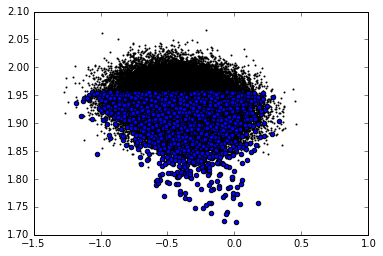

In [21]:
a,b=0,1

plt.scatter(IS_1comp[a], IS_1comp[b], s=1)
plt.scatter(postSamp_1comp[a],postSamp_1comp[b])
plt.show()

In [22]:
with open("./test_eod/sample_rv+Kepler/postSamp_rv+Kepler_2comp_2xl_overlap.txt") as f:
    lines = f.readlines()

tmp = np.transpose([ list(map(float,l.split())) for l in lines ])
postSamp_2comp = np.delete(tmp, 1, 0)

In [23]:
print(postSamp_2comp)

[[  1.60251248e-01   7.09933183e-01   6.02694436e-01 ...,   7.72845703e-01
    6.65576091e-01   7.85682427e-01]
 [ -4.35090217e+00  -1.40450871e+00  -8.30675281e-01 ...,  -3.47605200e-01
   -4.29587405e-01  -2.89891026e-01]
 [ -2.80656242e-01  -5.40044117e-01  -3.38735589e-01 ...,  -3.77580937e+00
   -8.01402214e-01  -3.40742697e+00]
 [  2.66302612e+00   2.46251155e+00   2.44600866e+00 ...,   1.94587550e+00
    1.88815242e+00   1.92578417e+00]
 [  1.94505190e+00   1.82174220e+00   1.78378591e+00 ...,   3.25881950e+00
    3.57012831e+00   3.42305359e+00]
 [  2.38817731e+01   7.47530994e+02   3.07425415e+01 ...,   2.58111103e+01
    2.70816839e+01   2.44047006e+01]]


In [24]:
IS_2comp = computeFML(postSamp_2comp, obs=Stan_data, nImportSamps=500000, model="2comp_mixed").importSamp
IS_2comp = np.transpose(IS_2comp)

## Drawing importance samples...
## Done drawing importance samples!

## Evaluating lnpost at importance samples...


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: divide by zero encountered in log


## Done evaluating lnpost!

1 -2.95126654307e+94
1001 -115.330833148
2001 -115.718017443
3001 -114.698866752
4001 -114.504640545
5001 -113.678911235
6001 -113.417011536
7001 -112.325845882
8001 -112.437282589
9001 -112.550253922
10001 -112.652057819
11001 -112.604255366
12001 -112.549112277
13001 -112.502435834
14001 -112.576054225
15001 -112.644518579
16001 -112.706688789
17001 -112.764767613
18001 -112.591486672
19001 -112.640666909
20001 -112.398692303
21001 -112.403867354
22001 -112.393983714
23001 -112.437141081
24001 -112.479303247
25001 -112.519638477
26001 -112.557985481
27001 -111.969918927
28001 -112.001044667
29001 -112.018011082
30001 -111.921910734
31001 -111.954071332
32001 -111.983543987
33001 -111.974139061
34001 -112.002667009
35001 -112.025467265
36001 -112.053376396
37001 -112.071550964
38001 -112.084530083
39001 -112.107351572
40001 -112.131204376
41001 -112.150127038
42001 -112.161356368
43001 -112.137702207
44001 -112.149927323
45001 -112.169324076
46001 -112.1650

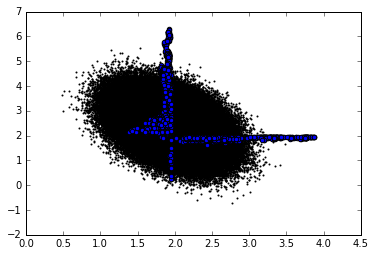

In [25]:
a,b=3,4

plt.scatter(IS_2comp[a], IS_2comp[b], s=1)
plt.scatter(postSamp_2comp[a],postSamp_2comp[b])
plt.show()